# Discharge curve analysis
Code development for plotting the dischard curve

In [1]:
%aiida
from toolchest.hull import get_relax_record_single, get_relax_records, get_entry, remove_composition_from_entries

from aiida.orm import StructureData

In [2]:
plt.style.use('../publication_mp_style')

In [3]:
migrated_glp = Group.objects.get(label='oxalates-f/li2feoxf2-migrated')
q = QueryBuilder()
q.append(Group, filters={'id': migrated_glp.id})
q.append(Node, with_group=Group)
q.append(StructureData)
q.append(WorkflowFactory('vaspu.delithiate'), project=['label', '*'], tag='work')
q.append(Dict, project=['attributes'], edge_filters={'label': 'output_voltages'})
q.append(WorkChainNode, with_incoming='work', edge_filters={'label': 'initial_relax'}, tag='init', project=['*'])
q.append(Dict, project=['attributes.total_energies.energy_extrapolated'])
_, work, _, init_relax, eng = q.first()

In [4]:
# Delithiated and lithiated structures

lithiated = get_relax_record_single(init_relax)
groups = [Group.objects.get(label=f'li2feoxf2/deli-2x1x1-full-nli-{key}') for key in [0, 1,2,3,4,5, 6, 7,8]]
groups.extend([Group.objects.get(label=f'li2feoxf2/deli-1x2x1-full-nli-{key}') for key in [1,2,3,4]])
delithiated = get_relax_records(groups, 520, functional='pbesol')
delithiated = delithiated[delithiated.functional == 'pbesol']
li_ref = get_relax_records([Group.objects.get(label='li-metal-refs')], 520, group_with_structures=False, functional='pbesol')
li_ref = li_ref[li_ref.functional == 'pbesol'][:1]


delithiated['entry'] = get_entry(delithiated)
lithiated['entry'] = get_entry(lithiated)
li_ref['entry'] = get_entry(li_ref)
# Store the number of Li ratio
delithiated['nli'] = delithiated.apply(lambda x: x.pmg_struct.composition['Li'] / 4.0, axis=1)

Entries: 197


  0%|          | 0/197 [00:00<?, ?it/s]

Entries: 4


  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
# Remove inconsistent entries
idx_remove = []
for idx, relax_id in delithiated.relax_uuid.items():
    node = load_node(relax_id)
    if node.exit_status == 601:
        scf_energy = node.outputs.misc['total_energies']['energy_extrapolated']
        q = QueryBuilder()
        q.append(Node, filters={'id': node.outputs.relax.structure.id})
        q.append(CalcJobNode, with_outgoing=Node)
        q.append(Dict, project=['attributes.total_energies.energy_extrapolated'])
        eng = q.one()[0]
        comp = node.inputs.structure.get_pymatgen().composition.reduced_formula
        diff = (scf_energy - eng) / len(node.inputs.structure.sites)
        print(f'Comp: {comp:<20}Eng SCF: {scf_energy:>10.3f} Eng RELAX: {eng:>10.3f}, DIFF:{diff:.3f}')
        if abs(diff) > 0.005:
            idx_remove.append(idx)
delithiated.drop(idx_remove, inplace=True)

Comp: Li3Fe2C4(O2F)4      Eng SCF:   -287.821 Eng RELAX:   -287.641, DIFF:-0.004
Comp: Li3Fe2C4(O2F)4      Eng SCF:   -287.759 Eng RELAX:   -287.868, DIFF:0.003
Comp: Li3Fe2C4(O2F)4      Eng SCF:   -287.833 Eng RELAX:   -287.845, DIFF:0.000
Comp: Li3Fe2C4(O2F)4      Eng SCF:   -287.828 Eng RELAX:   -287.656, DIFF:-0.004
Comp: Li3Fe2C4(O2F)4      Eng SCF:   -287.808 Eng RELAX:   -287.733, DIFF:-0.002
Comp: Li3Fe2C4(O2F)4      Eng SCF:   -287.107 Eng RELAX:   -287.109, DIFF:0.000
Comp: Li3Fe2C4(O2F)4      Eng SCF:   -287.832 Eng RELAX:   -287.758, DIFF:-0.002
Comp: Li3Fe2C4(O2F)4      Eng SCF:   -287.647 Eng RELAX:   -287.868, DIFF:0.005
Comp: Li3Fe2C4(O2F)4      Eng SCF:   -287.103 Eng RELAX:   -287.113, DIFF:0.000
Comp: Li3Fe2C4(O2F)4      Eng SCF:   -287.817 Eng RELAX:   -287.657, DIFF:-0.004
Comp: Li3Fe2C4(O2F)4      Eng SCF:   -287.832 Eng RELAX:   -287.759, DIFF:-0.002
Comp: Li3Fe2C4(O2F)4      Eng SCF:   -287.796 Eng RELAX:   -287.814, DIFF:0.000
Comp: Li3Fe2C4(O2F)4      Eng SCF:

In [6]:
from pymatgen.analysis.reaction_calculator import ComputedReaction
from pymatgen.analysis.phase_diagram import CompoundPhaseDiagram, PDPlotter

from aiida_user_addons.process import battery as vol
from importlib import reload
reload(vol)

from pymatgen.core import Element

In [7]:
last_entry = lithiated.iloc[0].entry
effective_entries = [li_ref.iloc[0].entry, last_entry]  # Collect  all enetries for the phase diagram
vols = [[2.0, lithiated.iloc[0].volume / lithiated.iloc[0].pmg_struct.composition['C'] * 2]]  # Tracker for the volume
for nli in sorted(delithiated.nli.unique(), reverse=True):
    row = delithiated[delithiated.nli == nli].sort_values('energy').iloc[0]
    entry = row.entry
    volume = row.volume
    reaction = ComputedReaction([last_entry], [entry, li_ref.iloc[0].entry])
    eng = reaction.calculated_reaction_energy
    dli = reaction.products[1].num_atoms * reaction.coeffs[2]
    print(reaction, eng / dli)
    print(f"label: {row.label} Volume : {volume:2f} {row.max_force}")
    #last_entry = entry
    effective_entries.extend(delithiated[delithiated.nli == nli].entry.to_list()[:1])
    tmp = delithiated[delithiated.nli == nli].iloc[0]
    vols.append([nli, tmp.volume / tmp.pmg_struct.composition['C'] * 2])
all_entries = list(effective_entries)
all_entries.extend(delithiated.entry.tolist())

4 Li2FeC2(O2F)2 -> Li7Fe4C8(O2F)8 + Li 3.8486877100000525
label: 2Li2FeOxF2-210405-201237-b074a1 RELAXED 1x2x1 DELI 1 1 RATTLED Volume : 460.057079 0.01982284100102
2 Li2FeC2(O2F)2 -> Li3Fe2C4(O2F)4 + Li 3.5241855500000243
label: 2Li2FeOxF2-210405-201237-b074a1 RELAXED 1x2x1 DELI 2 5 RATTLED Volume : 459.692632 0.029664196389813
4 Li2FeC2(O2F)2 -> Li5Fe4C8(O2F)8 + 3 Li 3.6280102599999786
label: 2Li2FeOxF2-210405-201237-b074a1 RELAXED 1x2x1 DELI 3 0 RATTLED Volume : 459.616757 0.021884765697757
Li2FeC2(O2F)2 -> LiFeC2(O2F)2 + Li 3.517784055000002
label: 2Li2FeOxF2-210405-201237-b074a1 RELAXED 2x1x1 DELI 4 1 RATTLED Volume : 465.510152 0.020827120658243
4 Li2FeC2(O2F)2 -> Li3Fe4C8(O2F)8 + 5 Li 3.944661752000035
label: 2Li2FeOxF2-210405-201237-b074a1 RELAXED 2x1x1 DELI 5 0 Volume : 459.048308 0.019837004853213
2 Li2FeC2(O2F)2 -> LiFe2C4(O2F)4 + 3 Li 4.172461869999974
label: 2Li2FeOxF2-210405-201237-b074a1 RELAXED 2x1x1 DELI 6 2 Volume : 460.713041 0.025758265041873
4 Li2FeC2(O2F)2 -> LiFe

In [49]:
import toolchest.phase_diagram as tpd
reload(tpd)

<module 'toolchest.phase_diagram' from '/home/bonan/appdir/python-tools/toolchest/phase_diagram.py'>

In [11]:
plt.rcParams['figure.dpi'] = 96

## Individual plots

In [8]:
curve = vol.VoltageCurve(remove_composition_from_entries(all_entries, 'Li'), li_ref.entry.iloc[0]
            )


fig, ax = plt.subplots(1, 1, figsize=(8, 6))

curve.plot_voltages(ax=ax)
plt.xlabel(r'$\mathrm{Li_{2-x}Fe(C_2O_4)F_2}$', fontsize=28)
plt.ylabel('Voltage (V)', fontsize=28)
plt.xticks(ticks=[0, 0.5, 1.0, 1.5, 2.0], fontsize=8*2.5)
plt.yticks(fontsize=8*2.5)
plt.ylim(3.0, 5.5)
plt.tight_layout()
plt.savefig('vcurve-li2feoxf2.svg')
#plt.savefig('../paper-plots/vcurve-li2feoxf2.png', dpi=200)


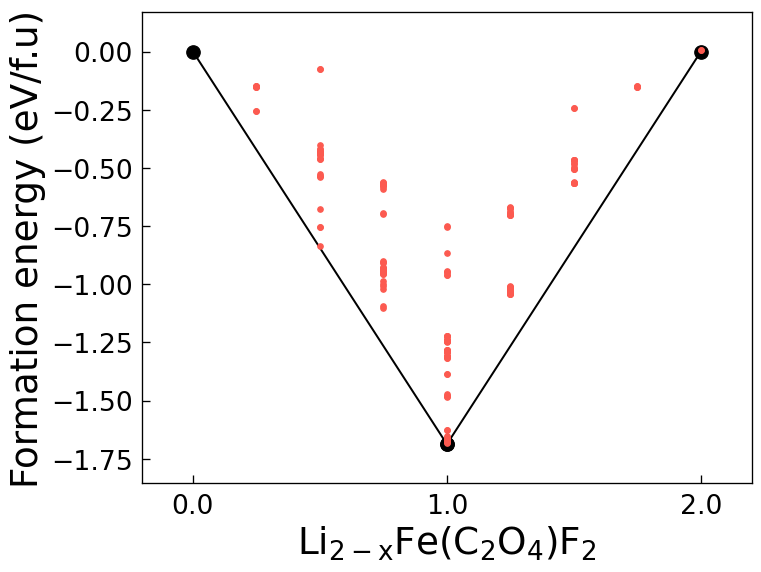

In [17]:
pdplotter = tpd.BetterMplPlotter(curve.phase_diagram, backend='matplotlib', markerfacecolor='k', markersize=10, 
                                 show_unstable=5.0)
pdplotter.get_plot(plt=plt, label_unstable=False, label_stable=False, energy_colormap=None, manual_stable_offsets={'Li2Fe2S2O': [50, 0]}, 
                   stable_label_size=20, no_polyanion=True)
plt.xlabel(r'$\mathrm{Li_{2-x}Fe(C_2O_4)F_2}$', fontsize=28)
ticks = np.array([0.0,0.5, 1.0])
plt.xticks(ticks, labels=ticks*2.0)
plt.tight_layout()
plt.savefig('vcurve-chull-li2feoxf2.svg')
#plt.savefig('../paper-plots/vcurve-chull-li2feoxf2.png', dpi=200)


## Combined

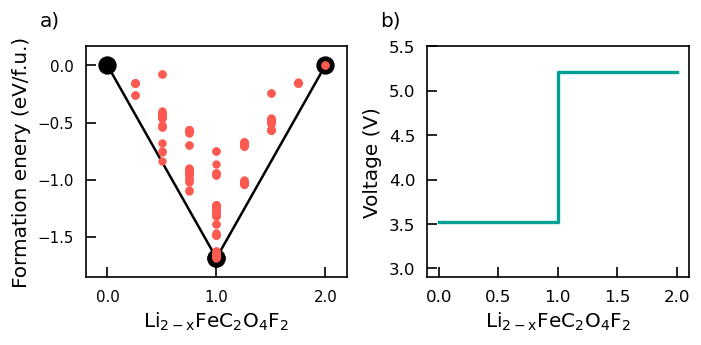

In [80]:
curve = vol.VoltageCurve(remove_composition_from_entries(all_entries, 'Li'), li_ref.entry.iloc[0]
            )


fig, ax = plt.subplots(1, 2, figsize=(6, 3))

curve.plot_voltages(ax=ax[1])
ax[1].lines[0].set_linewidth(2)
ax[1].set_xlabel(r'$\mathrm{Li_{2-x}FeC_2O_4F_2}$', fontsize=12)
plt.ylabel('Voltage (V)', fontsize=12)
plt.xticks(ticks=[0, 0.5, 1.0, 1.5, 2.0], fontsize=10)
plt.yticks(fontsize=10)


plt.sca(ax[0])
pdplotter = tpd.BetterMplPlotter(curve.phase_diagram, backend='matplotlib', markerfacecolor='k', markersize=10, 
                                 show_unstable=5.0)
pdplotter.get_plot(plt=plt, label_unstable=False, label_stable=False, energy_colormap=None, 
                   stable_label_size=12, no_polyanion=True)
ax[0].set_xlabel(r'$\mathrm{Li_{2-x}FeC_2O_4F_2}$', fontsize=12)
plt.ylabel(r'Formation enery (eV/f.u.)', fontsize=12)

ticks = np.array([0.0,0.5, 1.0])
plt.xticks(ticks, labels=ticks*2.0)
plt.tight_layout()
ax[1].set_ylim(2.9, 5.5)

ax[0].text(-0.1, 1.15, 'a)', transform=ax[0].transAxes,
      fontsize=12, va='top', ha='right')

ax[1].text(-0.1, 1.15, 'b)', transform=ax[1].transAxes,
      fontsize=12, va='top', ha='right')

fig.tight_layout()
#fig.savefig('voltage_profile.svg')
#fig.savefig('voltage_profile.png', dpi=200)
fig.savefig('voltage-profile-li2feoxf2.svg', dpi=200)


## Deposit into a dedicated group for further study
e.g. relaxation using HSE06

## Theoretical capacities

In [18]:
from toolchest.battery.metrics import TheoreticalCathode

catf = TheoreticalCathode('Li2FeC2O4F2', nli=1, avg_voltage=3.52)

cat = TheoreticalCathode('Li2FeC4O8', nli=1, avg_voltage=3.9)

print(cat.comp.reduced_formula, cat.Whkg)

print(cat.comp.reduced_formula, cat.mAhg)

print(catf.comp.reduced_formula, catf.Whkg)
print(catf.comp.reduced_formula, catf.mAhg)

Li2Fe(CO2)4 425.3078237679626
Li2Fe(CO2)4 109.05328814563144
Li2FeC2(O2F)2 481.9651670791162
Li2FeC2(O2F)2 136.921922465658


## C-C bond length

In [18]:
from aiida_user_addons.process.battery import DelithiationManager

from pymatgen.io.ase import AseAtomsAdaptor



def get_cc_bond_lengths(atoms):
    """Return the CC bond lenghs for an Atoms object. Assume each C has one C-C bond"""
    only_c = atoms[atoms.numbers == 6]
    dmat = only_c.get_all_distances(mic=True)
    dmat[dmat == 0.] = 999
    min_cc = dmat.min(axis=1)
    return min_cc

lowest = delithiated.loc[delithiated.groupby('formula').energy.idxmin()]


all_atoms = []
levels = []
mean_bonds = []
for entry in lowest.entry.tolist() + lithiated.entry.tolist():
    atoms = AseAtomsAdaptor.get_atoms(entry.structure)
    man = DelithiationManager(entry.structure)
    level = man.lithiation_level
    levels.append(level)
    bonds = get_cc_bond_lengths(atoms)
    all_atoms.append(atoms)
    mean_bond = bonds.mean()
    mean_bonds.append(mean_bond)
    #print(mean_bond, entry.composition.reduced_formula)

In [27]:
import pandas as pd

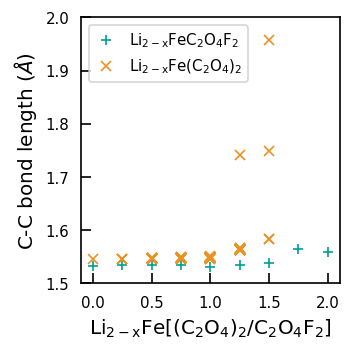

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
latex_li2feoxf2 = r'$\mathrm{Li_{2-x}FeC_2O_4F_2}$'
latex_li2feox2 = r'$\mathrm{Li_{2-x}Fe(C_2O_4)_2}$'
ax.plot(2 - np.array(levels), mean_bonds, '+', label=latex_li2feoxf2)
ax.set_xlabel(r'$\mathrm{Li_{2-x}Fe[(C_2O_4)_2/C_2O_4F_2}]$', fontsize=12)
ax.set_ylabel(r'C-C bond length ($\AA$)', fontsize=12)
ax.set_ylim(1.50, 2.0)

exp_frame = pd.read_csv('exp-c-c-bonds.csv')

ax.plot(exp_frame.li_level, exp_frame.mean_bonds, 'x', label=latex_li2feox2)
ax.legend()
plt.tight_layout()
plt.savefig('c-c-bond-pbesol.svg')
plt.savefig('c-c-bond-pbesol.svg')
plt.savefig('c-c-bond-pbesol.png', dpi=200)

## Read site projected magneitsations

Site projected magnetisation can be useful for analyse the oxidation states

In [20]:
plt.rcParams['figure.dpi'] = 120

In [21]:
from parsevasp.outcar import Outcar

import aiida.orm as orm

def get_magnetic_dict(relax):
    
    """
    Find the average site project magnetisation for each speice
    """
    q = QueryBuilder()
    q.append(Node, filters={'id': relax.id})
    q.append(Dict, tag='misc')
    q.append(CalcJobNode, with_outgoing='misc')
    q.append(orm.FolderData, project=['*'])
    q.append(orm.StructureData, with_outgoing=CalcJobNode, project=['*'])
    folder, struct = q.one()
    symbols = [s.kind_name for s in struct.sites]
    with folder.open('OUTCAR') as fh:
        parser = Outcar(file_handler=fh)
    magdict = parser.get_magnetization()
    return magdict

def magnetisation_by_specie(relax):
    """
    Find the average site project magnetisation for each speice
    """
    q = QueryBuilder()
    q.append(Node, filters={'id': relax.id})
    q.append(Dict, tag='misc')
    q.append(CalcJobNode, with_outgoing='misc')
    q.append(orm.FolderData, project=['*'])
    q.append(orm.StructureData, with_outgoing=CalcJobNode, project=['*'])
    folder, struct = q.one()
    symbols = [s.kind_name for s in struct.sites]
    with folder.open('OUTCAR') as fh:
        parser = Outcar(file_handler=fh)
    magdict = parser.get_magnetization()
    
    site_moments = magdict['sphere']['x']['site_moment']
    # Sum for each specie
    result = {key: 0.0 for key in set(symbols)}
    for idx, value in site_moments.items():
        symbol = symbols[idx-1]
        result[symbol] += value['tot']
    # Divid by counts of each specie
    comp = struct.get_pymatgen().composition
    for key in result.keys():
        result[key] /= comp[key]
    return result

In [25]:
# Extract the magnetisation of Fe atoms
delithiated['fe-mag'] = delithiated.relax_uuid.apply(lambda x:  magnetisation_by_specie(load_node(x))['Fe'])
delithiated['mag-dict'] = delithiated.relax_uuid.apply(lambda x:  get_magnetic_dict(load_node(x)))

In [24]:
# Extract the magnetisation of Fe atoms
lithiated['fe-mag'] = lithiated.relax_uuid.apply(lambda x:  magnetisation_by_specie(load_node(x))['Fe'])
lithiated['mag-dict'] = lithiated.relax_uuid.apply(lambda x:  get_magnetic_dict(load_node(x)))

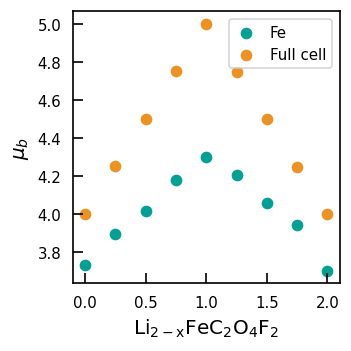

In [38]:
# Extract and plot the magnetisations

lowest = delithiated.loc[delithiated.groupby('formula').energy.idxmin()]


# Extract and plot the magnetisations
all_atoms = []
levels = []
tot_mag = []
fe_mag = []

for entry in lowest.entry.tolist() + lithiated.entry.tolist():
    atoms = AseAtomsAdaptor.get_atoms(entry.structure)
    man = DelithiationManager(entry.structure)
    level = man.lithiation_level
    levels.append(level)
    all_atoms.append(atoms)
    row = delithiated.loc[entry.parameters['dataframe_idx']]
    if level == 2.0:
        row = lithiated.loc[entry.parameters['dataframe_idx']]
        #print(row)
    tot_mag.append(row['mag-dict']['full_cell'][0] / entry.structure.composition['Fe'])
    fe_mag.append(row['fe-mag'])
    #print(row['fe-mag'], entry.composition.reduced_formula)


fig, ax = plt.subplots(1, 1, figsize=(3,3))


plt.scatter(2 - np.array(levels), fe_mag, label='Fe')
plt.ylabel(r'$\mu_b$', fontsize=12)
    
plt.scatter(levels, tot_mag, label='Full cell')
plt.xlabel(r'$\mathrm{Li_{2-x}FeC_2O_4F_2}$', fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig('fe-magnetisation-pbesol.svg')


## Create combined plot for the paper

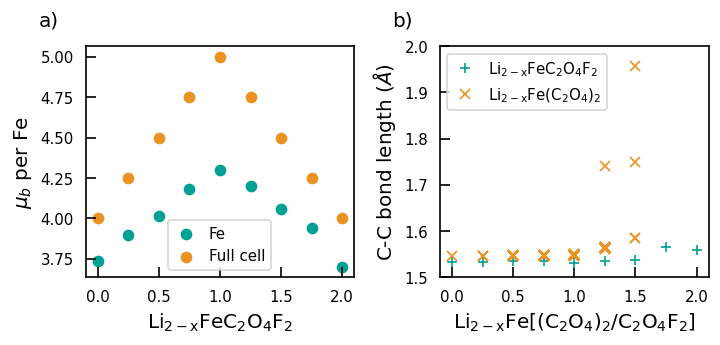

In [84]:
# Part1: Extract and plot the magnetisations

lowest = delithiated.loc[delithiated.groupby('formula').energy.idxmin()]


# Extract and plot the magnetisations
all_atoms = []
levels = []
tot_mag = []
fe_mag = []
mean_bonds = []

for entry in lowest.entry.tolist() + lithiated.entry.tolist():
    atoms = AseAtomsAdaptor.get_atoms(entry.structure)
    man = DelithiationManager(entry.structure)
    level = man.lithiation_level
    levels.append(level)
    all_atoms.append(atoms)
    row = delithiated.loc[entry.parameters['dataframe_idx']]
    if level == 2.0:
        row = lithiated.loc[entry.parameters['dataframe_idx']]
        #print(row)
    tot_mag.append(row['mag-dict']['full_cell'][0] / entry.structure.composition['Fe'])
    fe_mag.append(row['fe-mag'])
    bonds = get_cc_bond_lengths(atoms)
    mean_bond = bonds.mean()
    mean_bonds.append(mean_bond)
        
    #print(row['fe-mag'], entry.composition.reduced_formula)

latex_li2feoxf2 = r'$\mathrm{Li_{2-x}FeC_2O_4F_2}$'
latex_li2feox2 = r'$\mathrm{Li_{2-x}Fe(C_2O_4)_2}$'

fig, ax = plt.subplots(1, 2, figsize=(6,3))


ax[0].scatter(2 - np.array(levels), fe_mag, label='Fe')
ax[0].set_ylabel(r'$\mu_b$ per Fe', fontsize=12)
    
ax[0].scatter(2 - np.array(levels), tot_mag, label='Full cell')
ax[0].set_xlabel(latex_li2feoxf2, fontsize=12)
ax[0].legend()

ax[1].plot(2 - np.array(levels), mean_bonds, '+', label=latex_li2feoxf2)
ax[1].set_xlabel(r'$\mathrm{Li_{2-x}Fe[(C_2O_4)_2/C_2O_4F_2}]$', fontsize=12)
ax[1].set_ylabel(r'C-C bond length ($\AA$)', fontsize=12)
ax[1].set_ylim(1.50, 2.0)

exp_frame = pd.read_csv('exp-c-c-bonds.csv')

ax[1].plot(exp_frame.li_level, exp_frame.mean_bonds, 'x', label=latex_li2feox2)
ax[1].legend()

ax[0].text(-0.1, 1.15, 'a)', transform=ax[0].transAxes,
      fontsize=12, va='top', ha='right')

ax[1].text(-0.1, 1.15, 'b)', transform=ax[1].transAxes,
      fontsize=12, va='top', ha='right')

fig.tight_layout()

fig.savefig('cc-and-mag-combined.svg')
fig.savefig('cc-and-mag-combined.svg', dpi=200)
